In [45]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd as psd_func
from pycbc.filter import overlap_cplx
from pycbc.types import TimeSeries
from pycbc.waveform import taper_timeseries
from pycbc.psd import aLIGOZeroDetHighPower
import astropy.constants as aconst
import scipy.constants as const
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from pesummary.gw.conversions.mass import component_masses_from_mtotal_q
from simple_pe.waveforms import generate_eccentric_waveform, make_waveform, compute_s_factor, shifted_f, shifted_e

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [127]:
def dP_dt(f, e, m_total, q):

    prefactor = -192*np.pi/(5*const.c**5)
    P_term = (np.pi*const.G*f)**(5/3)
    m1, m2 = component_masses_from_mtotal_q(m_total, q)
    m1 *= aconst.M_sun.value
    m2 *= aconst.M_sun.value
    m_term = m1*m2/(m1+m2)**(1/3)
    e_term = (1+(73/24)*e**2+(37/96)*e**4)/(1-e**2)**(7/2)

    return prefactor*P_term*m_term*e_term

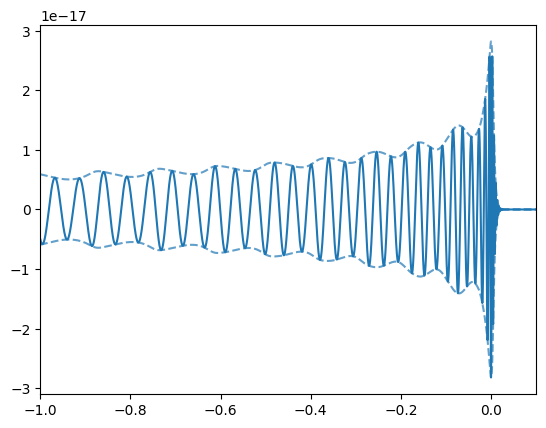

In [136]:
def teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, phase=0,
            inclination=0, distance=1, f_ref_e=None,
            tlen=None, taper=True, to_fs=True,
            mode_array=[[2, 2]]):

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': M,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination
    }
    t, hp, hc, _, _ = EOBRun_module.EOBRunPy(pars)
    tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    if tlen is not None:
        hp.resize(tlen*s_rate)
        hc.resize(tlen*s_rate)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc

def get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen):

    s_f = shifted_f(f_gen, e, M, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = teob_wf(M, q, s_e, chi1, chi2,
                         s_f, s_rate, tlen=tlen,
                         taper=False, to_fs=False)
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out shift correction factor by examining peaks of both waveforms
        s_factor = compute_s_factor(h, s_wf)

    else:
        s_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    return s_f_vals, s_e_vals


def gen_component_wfs_test(M, q, e, chi1, chi2, f_gen, f_low, s_rate, phase,
                          inclination, distance, tlen, n_ecc_gen, psd=None):

    # Get psd into correct format if inputted
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)

    # Calculates first component waveform and shifts required for others
    hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate,
             phase=phase, inclination=inclination,
             distance=distance, tlen=tlen,
             taper=False, to_fs=False)
    h = hp - 1j*hc
    s_f_vals, s_e_vals = get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate,
                                              tlen, n_ecc_gen)

    # Taper first waveform
    h_taper_p = taper_timeseries(h.real(), tapermethod='start')
    h_taper_c = taper_timeseries(-h.imag(), tapermethod='start')
    h = h_taper_p - 1j*h_taper_c

    # Calculates psd if not inputted
    if psd is None:
        h.resize(2**np.ceil(np.log2(len(h))))
        delta_f = 1.0 / h.duration
        flen = len(h)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}

    # Save first component waveform
    h_ts = h.sample_times
    h_dt = h.delta_t
    h_start = h.start_time
    comp_wfs = {key: [h] for key in psd_dict.keys()}

    # Generate all component waveforms
    for i in range(n_ecc_gen-1):

        # Create waveform
        hp, hc = teob_wf(M, q, s_e_vals[i], chi1, chi2,
                         s_f_vals[i], s_rate, phase=phase,
                         inclination=inclination,
                         distance=distance, tlen=tlen,
                         to_fs=False, taper=False)
        h = hp - 1j*hc
        comp_start = h.sample_times[0]

        # Trim waveform to same size as first (shortest)
        wf_trim_interpolate = interp1d(h.sample_times, h, bounds_error=False,
                                       fill_value=0)
        wf_trim_strain = wf_trim_interpolate(h_ts)
        h = TimeSeries(wf_trim_strain, h_dt,
                       epoch=h_start)

        # Correct phase and taper for each psd
        for key in psd_dict.keys():

            # Calculate phase shift
            ft_interp = interp1d([comp_wfs[key][0].sample_times[0], comp_start],
                                 [f_gen, s_f_vals[i]], kind='linear')
            ts = np.linspace(comp_wfs[key][0].sample_times[0], comp_start, 10**5)
            fs = ft_interp(ts)
            es = shifted_e(fs, f_gen, e)
            P_0 = 2/f_gen
            cum_P = integrate.cumulative_trapezoid(dP_dt(fs, es, M, q), ts, initial=0)
            delta_phi = -4*np.pi*integrate.trapezoid(1/(cum_P+P_0), ts)
            h_psd = h*np.exp(1j*delta_phi)

            # Re-taper waveform after trimming
            h_taper_p = taper_timeseries(h_psd.real(), tapermethod='start')
            h_taper_c = taper_timeseries(-h_psd.imag(), tapermethod='start')
            h_psd = h_taper_p - 1j*h_taper_c

            comp_wfs[key].append(h_psd)

    return comp_wfs, psd_dict

comp_wfs =  gen_component_wfs_test(60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                   0, 1, 32, 50, psd=None)[0]['psd']
h0 = comp_wfs[0].copy()
for i in range(1, len(comp_wfs)):
    h0 += comp_wfs[i]
plt.plot(h0.sample_times, h0, c='C0')
plt.plot(h0.sample_times, np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.plot(h0.sample_times, -np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.xlim(-1, 0.1)
plt.show()

In [129]:
## TESTING - ONLY WORKS IF DISABLE PHASE CORRECTION, TRIMMING, AND TAPERING ABOVE
first_wf = comp_wfs[0]
test_wf = comp_wfs[4]

first_phis = np.angle(first_wf)
phi_interp = interp1d(first_wf.sample_times, first_phis, kind='linear', fill_value='extrapolate')


ft_interp = interp1d([first_wf.sample_times[0], test_wf.sample_times[0]],
                     [10, 9.74787623], kind='linear')
ts = np.linspace(first_wf.sample_times[0], test_wf.sample_times[0], 10**5)
P_0 = 2/10
phi_0 = np.angle(first_wf[0])
cum_P = integrate.cumulative_trapezoid(dP_dt(ft_interp(ts), 0.4, 60, 2), ts, initial=0)
delta_phi = -4*np.pi*integrate.trapezoid(1/(cum_P+P_0), ts) + phi_0


print(delta_phi)

0.0
